# Competition between lesions of septoria and brown rust on a single leaf

This notebook details an exercice mimicking the competition between lesions of septoria and brown rust on a wheat leaf. The graphical outputs can be used to interpret the results of the competition in Alep septo-rust coupled model.

_Author: G. Garin (iTK) - 30/04/2015_

In [1]:
import numpy as np
import pandas as pd
from pylab import *
from IPython.display import *
from alinea.alep.alep_color import cmap_competition

%matplotlib inline
rcParams['figure.figsize']=(8,8)
cmap, bounds, norm = cmap_competition()
import matplotlib.gridspec as gridspec

Biological behavior assumed for competition
-------------------------------------------
* Lesions of septoria grow with a rectangular shape
* Lesions of brown rust grow with a circular shape
* Lesions have a maximal size specific of the pathogen
* Assuming an optimal distribution and no competition, lesion growth is ultimately limited by leaf size
* Two lesions of brown rust can not share the same leaf tissue
* Two lesions of septoria in incubation stage can not share the same leaf tissue
* One lesion of septoria in incubation stage and one lesion of brown rust can not share the same leaf tissue
* In this case, lesion growth stops at the frontier of contact with another lesion but continues on the rest of the periphery
* The maximal size of a lesion is reduced if it competes with others
* One lesion of septoria can grow over a lesion of brown rust and eliminate it if the lesion of septoria has passed incubation
* The latency period of brown rust is shorter than the one of septoria
* After the latency period, mother lesions produce daughter lesions on the same leaf
* Lesions of brown rust produce daughter lesions more frequently

Algorithm
---------
* Step 1: Simulation of a leaf as a rectangle domain
* Step 2: Initialisation of the first lesions
* Simulation loop: For each time step:
    * Step 3: New lesions emerge at a predetermined pace (latency period - pathogen specific)
    * Step 4: Growth of each lesion 
    * Step 5: Spatialization of the lesions and competition between them
    * Step 6: Visualisation of the leaf status

### Step 1 : Simulation of a leaf as a square domain (image)

The leaf is represented as a simple rectangle with a fixed limited size.

* Model parameters: 
    * domain = length $L$, width $W$
    * size of a pixel = $dL$, $dW$ 

In [2]:
L, W = 10, 3
dL, dW = 0.01, 0.01
#dL, dW = 0.1, 0.1
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
X, Y = leaf.shape

### Step 2 : Initialization of the first lesions

A lesion of septoria is represented as a growing rectangle colonizing pixels of leaf. There are two rates of expansion: rate in length > rate in width ($ratio = 4$)

* Lesion object: $lesion = {x, y, lid, dS, age, l, w}$
    - constant values: position = $(x, y)$ , identifier = $lid$, growth rate = $dS$, emission rate (nb of daughters/cm²) = $dE$, surface max of the lesion = $Smax$, age of start of chlorosis = $age chlo$, age of start of sporulation = $age spo$
    - age of the lesion = $age$
    - length (resp. width) of the lesion =$(l, w)$
    - activity of the lesion = $is active$

In [3]:
class SeptoLesion(object):
    lid = 0.
    ratio = 4.
    dS = 0.0006
    dS0 = 0.03/220.
    dE = 1.7
    age_chlo = 220
    age_spo = 330
    # Temp G. Garin 27/01/2016 : Test no growth during incubation
    #age_grow = 200.
    #dS0 = 0.03/20.
    def __init__(self, x, y, lid = None):
        self.age = 0
        self.x = x
        self.y = y
        #self.w = 0.03/self.ratio
        self.w = 0.
        self.l = self.ratio * self.w
        self.Smax = 0.3
        SeptoLesion.lid += 1
        self.lid = SeptoLesion.lid
        self.is_active = True
        self.emission_is_active = True
        self.surface_empty = 0
        self.dw = 0.
        
    def reset(self):
        SeptoLesion.lid=0

    def growth(self, dt):
        if self.is_active and self.pot_surface <= self.Smax:
            if self.age == 0.:
                self.w = np.sqrt(self.dS0/4.)
                # self.w = 0.
            elif self.age < self.age_chlo:
                self.dw = self.dS0/(4*self.w + self.l)
                # Temp G. Garin 27/01/2016 : Test no growth during incubation
                #if self.age >= self.age_grow:
                 #   self.w = np.sqrt(self.dS0/4.)
                  #  self.dw = self.dS0/(4*self.w + self.l)
            elif self.age >= self.age_chlo :
                self.dw = self.dS/(4*self.w + self.l)
            self.dl = self.ratio*self.dw
            self.l += self.dl*dt
            self.w += self.dw*dt
            self.age += dt
    
    def emission(self):
        if  self.emission_is_active and self.age >= self.age_spo:
            emission = (self.surface-self.surface_empty) * self.dE
            self.surface_empty = self.surface
            if self.surface_empty == self.Smax:
                self.disable_emission()
            return emission
        else:
            return 0.
        
    def disable(self):
        self.is_active = False
        self.emission_is_active = False
    
    def disable_emission(self):
        self.emission_is_active = False
    
    @property
    def pot_surface(self):
        return self.l*self.w
    
    @property
    def surface(self):
        if size(self.pixels) > 0.:
            return self.pot_surface * size(self.pixels) / size(leaf[self.pixels_total])
        else:
            return 0.

    @property
    def pixels_total(self):
        """ Pixels occupied by the lesion without competition """
        px, py = int(self.x*X), int(self.y*Y)
        pdx, pdy =  max(1,int(self.l/(2*dL))), max(1,int(self.w/(2*dW)))
        return slice(max(0,px - pdx), min(px + pdx,X)), slice(max(0,py - pdy), min(Y,py + pdy))
    
    @property
    def pixels(self):
        """ Pixels actually occupied by the lesion """
        return leaf[self.pixels_total][leaf[self.pixels_total]==self.lid]
    
    @property
    def is_incubating(self):
        return True if self.age < self.age_chlo else False
    
    @property
    def is_chlorotic(self):
        return True if self.age >= self.age_chlo and self.age < self.age_spo else False
    
    @property
    def is_sporulating(self):
        return True if self.age >= self.age_spo else False

A lesion of rust is represented as a growing circle colonizing pixels of leaf. There is one rate of expansion of the radius ($ratio = 4$)

* Lesion object: $lesion = {x, y, lid, k, x0, age, l, w}$
    - constant values: position = $(x, y)$ , identifier = $lid$, slope of growth curve = $k$, age at 50% of growth curve = $x0$, emission rate (nb of daughters/cm²) = $dE$, surface max of the lesion = $Smax$, age of start of sporulation = $age spo$, age of end of sporulation = $age end spo$, ratio of surface that can sporulate = $ratio spo$
    - age of the lesion = $age$
    - radius of the lesion = $r$
    - activity of the lesion = $is active$

In [4]:
class RustLesion(object):
    lid = 0.
    k = 0.015
    x0 = 350.
    # dE = 1.7
    dE = 20.
    age_spo = 180
    age_end_spo = 800
    ratio_spo = 0.3
    def __init__(self, x, y):
        self.age = 0
        self.x = x
        self.y = y
        self.pot_surface = 0.
        self.Smax = 0.09
        RustLesion.lid -= 1
        self.lid = RustLesion.lid
        self.is_active = True
        
    def reset(self):
        RustLesion.lid=0

    def logistic(self, x):
        return self.Smax/(1.+np.exp(-self.k*(x-self.x0)))
    
    def growth(self, dt):
        if self.is_active:
            self.pot_surface += self.logistic(self.age+dt) - self.logistic(self.age)
            self.age += dt
            if round(self.pot_surface,6)==self.Smax and self.age >= self.age_end_spo:
                self.disable()
    
    def emission(self):
        if self.is_active and self.age >= self.age_spo and self.age < self.age_end_spo: 
            return self.surface * self.dE
        else:
            return 0.
    
    def disable(self):
        self.is_active = False
    
    @property
    def r(self):
        return np.sqrt(self.pot_surface/np.pi)
    
    @property
    def surface(self):
        if size(self.pixels) > 0.:
            return self.pot_surface * size(self.pixels) / size(leaf[self.pixels_total])
        else:
            return 0.

    @property
    def pixels_total(self):
        """ Pixels occupied by the lesion without competition """
        px, py = self.x*L, self.y*W
        pdx, pdy = np.ogrid[-px:L-px:dL, -py:W-py:dW]
        return pdx*pdx + pdy*pdy <= self.r*self.r
    
    @property
    def pixels_spo(self):
        """ Pixels occupied by the area sporulating on the lesion without competition """
        px, py = self.x*L, self.y*W
        pdx, pdy = np.ogrid[-px:L-px:dL, -py:W-py:dW]
        #return pdx*pdx + pdy*pdy <= (self.ratio_spo*self.r)**2
        # Competition effect on sporulating area
        #ratio_compet = len(self.pixels)/float(len(leaf[self.pixels_total]))
        #return pdx*pdx + pdy*pdy <= self.ratio_spo*(self.r**2)*ratio_compet
        rows, cols = np.where(leaf==self.lid)
        centroid = (np.mean(rows), np.mean(cols))
        spo = sorted([(r,c) for r,c in zip(rows, cols)], 
                     key=lambda (x,y): np.sqrt((centroid[0]-x)**2 + (centroid[1]-y)**2))[:int(round(len(rows)*self.ratio_spo))]
        lf = np.zeros((int(L/dL), int(W/dW)), dtype=bool)
        lf[zip(*spo)] = True
        return lf
        
   
    @property
    def pixels_non_spo(self):
        """ Pixels occupied by the non sporulating area on the lesion without competition """
        return (True-self.pixels_spo)*self.pixels_total
    
    @property
    def pixels(self):
        """ Pixels actually occupied by the lesion """
        return leaf[self.pixels_total][leaf[self.pixels_total]==self.lid]

* Simple competition model: compute free space for each lesion to grow in its neighbourhood. Lesions are automatically sorted from older to younger. Priority is thus given to older lesions.

In [5]:
def simple_competition(leaf, lesions):
    for lesion in lesions:
        to_fill = lesion.pixels_total
        lid = lesion.lid
        leaf[to_fill] = np.where(leaf[to_fill] == 0, lid, leaf[to_fill])
    return leaf

* Biological competition model: compute free space for each lesion to grow in its neighbourhood. Priority is given to lesions of septoria in stage > chlorosis, that can grow over other lesions. Competition by other lesions is calculated as in 'simple_competition'.

In [6]:
def biological_competition(leaf, lesions):
    old_septo = [l for l in lesions if isinstance(l, SeptoLesion) and (l.is_chlorotic or l.is_sporulating)]
    np.random.shuffle(old_septo)
    for lesion in old_septo:
        to_fill = lesion.pixels_total
        lid = lesion.lid
        leaf[to_fill] = np.where(leaf[to_fill] <= 0, lid, leaf[to_fill])
    
    other_les =  [l for l in lesions if isinstance(l, RustLesion) or (isinstance(l, SeptoLesion) and l.is_incubating)]
    np.random.shuffle(other_les)
    for lesion in lesions:
        to_fill = lesion.pixels_total
        lid = lesion.lid
        leaf[to_fill] = np.where(leaf[to_fill] == 0, lid, leaf[to_fill])
        if size(leaf[to_fill])>0 and not any(leaf[to_fill]==lesion.lid):
            lesion.disable()
    return leaf

* Initialization/emergence model: new lesions emerge with a random distribution. New lesions can only emerge on a free space. Model parameters: 
  - Model of lesion : 'SeptoLesion' or 'RustLesion'
  - Competition model : 'simple_competition' or 'biological_competition'
  - Number of lesions = $n$

In [7]:
def init_lesion(leaf, LesionModel = SeptoLesion, competition_model = simple_competition, n=10):
    X, Y = leaf.shape
    for i in range(n):
        x, y = np.random.random(2)
        px, py = int(x*X), int(y*Y)
        if leaf[px,py]==0:
            lesions.append(LesionModel(x,y))
        
    leaf = competition_model(leaf, lesions)
    return leaf

* Dispersal model: get number of emissions determined by sporulating lesions of given species and distribute them on the leaf. New lesions can only emerge on a free space.
  - Model of lesion : 'SeptoLesion' or 'RustLesion'
  - Competition model : 'simple_competition' or 'biological_competition'

In [8]:
def disperse_lesion(leaf, lesions, LesionModel = SeptoLesion, competition_model = simple_competition):
    X, Y = leaf.shape
    n = int(round(sum([l.emission() for l in lesions if isinstance(l, LesionModel)])))
    for i in range(n):
        x, y = np.random.random(2)
        px, py = int(x*X), int(y*Y)
        if leaf[px, py]==0:
            lesions.append(LesionModel(x,y))

    leaf = competition_model(leaf, lesions)
    return leaf

* Plot the leaf with different colors for different types of lesions

In [9]:
def plot_leaf(leaf, lesions, return_leaf = False, ax=None):
    leaf_color = np.array([[np.array([148, 225, 136])/255. for i in range(len(line))] for line in leaf])
    # Plot lesions of septoria in different stages
    for l in lesions:
        if isinstance(l, SeptoLesion):
            if l.is_chlorotic:
                leaf_color[np.where(leaf==l.lid)] = np.array([253, 224, 76])/255.
            else:
                leaf_color[np.where(leaf==l.lid)] = np.array([255, 128, 0.])/255.
        else:
            spo = l.pixels_spo
            leaf_color[np.where((leaf==l.lid) & (spo))] = np.array([255., 0., 0.])/255.
            non_spo = l.pixels_non_spo
            leaf_color[np.where((leaf==l.lid) & (non_spo))] = np.array([1., 1., 0.])
    if return_leaf == True:
        return leaf_color.transpose((1,0,2))
    elif ax is None:
        fig = imshow(leaf_color.transpose((1,0,2)), interpolation = 'nearest')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    else:
        ax.imshow(leaf_color.transpose((1,0,2)), interpolation = 'nearest')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

* Smoothing functions to plot severity at any resolution

In [10]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [11]:
def plot_smooth(x, y, ax=None, box_pts=None, **kwds):
    if ax == None:
        fig, ax = plt.subplots()
    if box_pts == None:
        box_pts = len(x)/10
    ax.plot(np.concatenate((x, np.arange(x[-1],x[-1]+box_pts))),
            smooth(np.concatenate((y, np.ones(box_pts)*max(y))), box_pts), **kwds)    

## Test the growth curve of single lesions

* Compare the growth curve of a lesion of septoria without competition to analytical calculation

In [42]:
L, W = 1.5, 0.5
dL, dW = 0.01, 0.01
ind_leaf = np.arange(L/dL * W/dW).reshape(L/dL, W/dW)
X, Y = leaf.shape
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
SeptoLesion.lid = 0
lesion = SeptoLesion(0.5,0.5)
leaves = []
ages = [250., 500., 750]
s_lesion = []
for i in range(1000):
    lesion.growth(dt=1.)
    leaf = biological_competition(leaf, [lesion])
    s_lesion.append(lesion.surface)
    if i in ages:
        leaves.append(plot_leaf(leaf, [lesion], return_leaf = True))

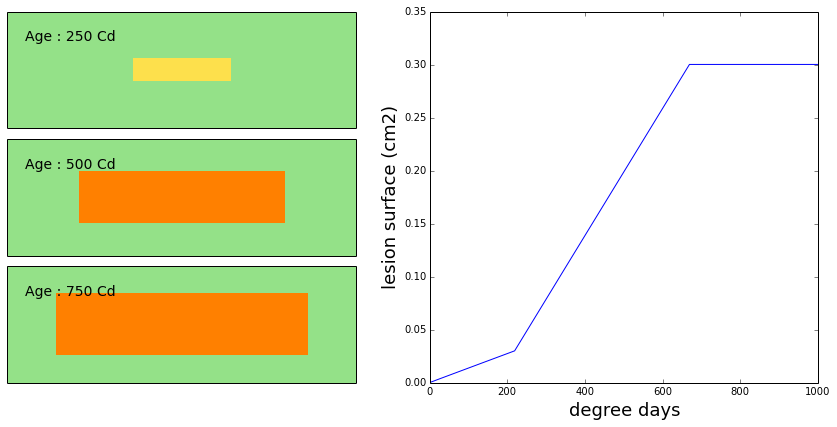

In [43]:
%matplotlib inline
rcParams['figure.figsize']=(12,6)
gs = gridspec.GridSpec(3, 2)
for i, a in enumerate(ages):
    ax = plt.subplot(gs[i, 0])
    ax.imshow(leaves[i], interpolation = 'nearest')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.annotate('Age : %d Cd' %a, xy=(0.05, 0.75), 
                xycoords='axes fraction', fontsize=14)
ax = plt.subplot(gs[:, 1])
ax.plot(s_lesion)
ax.set_ylabel('lesion surface (cm2)', fontsize = 18)
ax.set_xlabel('degree days', fontsize = 18)
plt.tight_layout()
rcParams['figure.figsize']=(8,8)

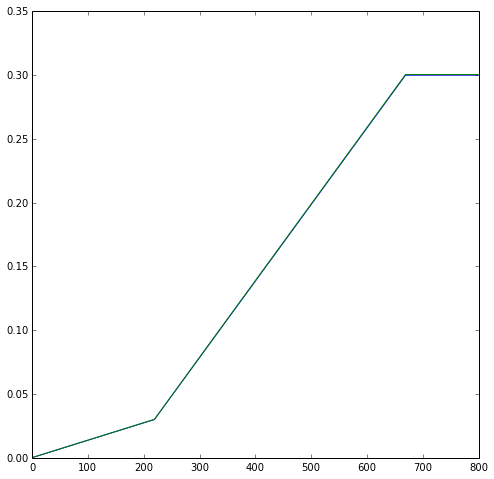

In [44]:
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
lesion = SeptoLesion(0.5,0.5)
s_analytic = []
s_lesion = []
surf = 0
smax = 0.3
for i in range(800):
    if i < lesion.age_chlo:
        surf += 0.03/220.
    else:
        surf += 0.0006
    s_analytic.append(min(smax, surf))
    
    lesion.growth(1.)
    s_lesion.append(lesion.pot_surface)
plot(s_analytic)
plot(s_lesion)

* Compare the growth curve of a lesion of brown rust without competition to logistic growth in other model

In [45]:
L, W = 1.5, 0.5
dL, dW = 0.01, 0.01
ind_leaf = np.arange(L/dL * W/dW).reshape(L/dL, W/dW)
X, Y = leaf.shape
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
RustLesion.lid = 0
lesion = RustLesion(0.5,0.5)
leaves = []
ages = [100., 300., 500.]
s_lesion = []
for i in range(1000):
    lesion.growth(dt=1.)
    leaf = biological_competition(leaf, [lesion])
    s_lesion.append(lesion.pot_surface)
    if i in ages:
        leaves.append(plot_leaf(leaf, [lesion], return_leaf = True))

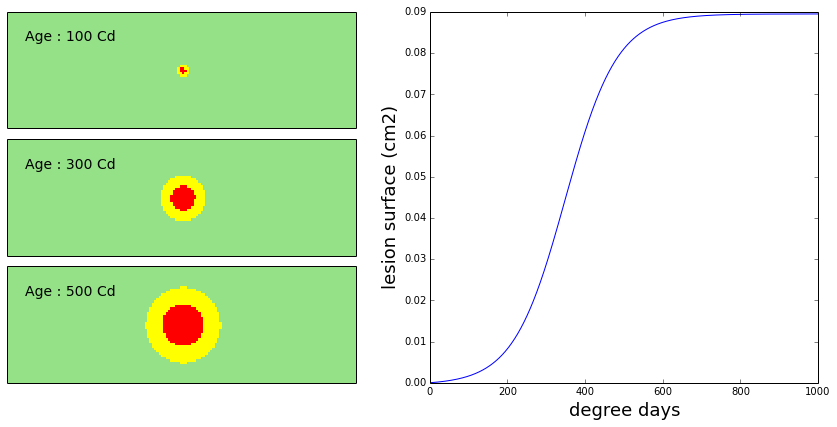

In [46]:
rcParams['figure.figsize']=(12,6)
gs = gridspec.GridSpec(3, 2)
for i, a in enumerate(ages):
    ax = plt.subplot(gs[i, 0])
    ax.imshow(leaves[i], interpolation = 'nearest')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.annotate('Age : %d Cd' %a, xy=(0.05, 0.75), 
                xycoords='axes fraction', fontsize=14)
ax = plt.subplot(gs[:, 1])
ax.plot(s_lesion)
ax.set_ylabel('lesion surface (cm2)', fontsize = 18)
ax.set_xlabel('degree days', fontsize = 18)
plt.tight_layout()
rcParams['figure.figsize']=(8,8)

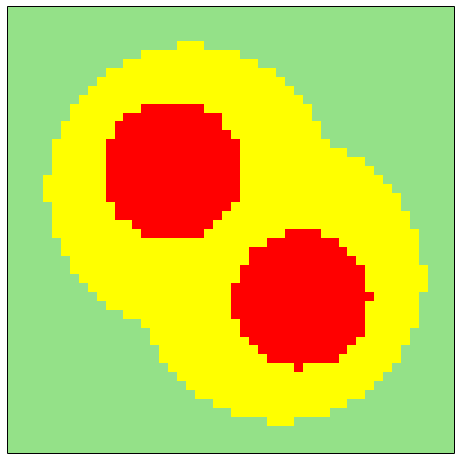

In [47]:
L, W = 0.5, 0.5
dL, dW = 0.01, 0.01
ind_leaf = np.arange(L/dL * W/dW).reshape(L/dL, W/dW)
X, Y = leaf.shape
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
RustLesion.lid = 0
lesions = []
lesions.append(RustLesion(0.4,0.4))
lesions.append(RustLesion(0.6,0.6))
for i in range(500):
    for lesion in lesions:
        lesion.growth(dt=1.)
        leaf = biological_competition(leaf,lesions)
plot_leaf(leaf, lesions)

## Test the competition intra-species

* Competition between lesions of septoria without rust

In [12]:
L, W = 10, 3
dL, dW = 0.01, 0.01
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
X, Y = leaf.shape

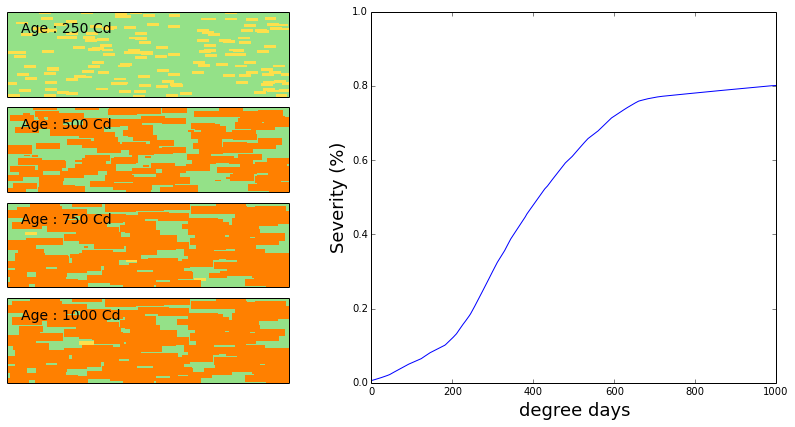

In [13]:
from scipy.interpolate import UnivariateSpline
lesions = []
SeptoLesion.lid = 0
leaf[:,:]=0
leaf = init_lesion(leaf, LesionModel = SeptoLesion, n=150)
nb_steps = 1000
sev_septo = []
ddays = []
nb_les = []

rcParams['figure.figsize']=(12,6)
gs = gridspec.GridSpec(4, 2)
ax_dict = {250:plt.subplot(gs[0, 0]), 500:plt.subplot(gs[1, 0]), 750:plt.subplot(gs[2, 0]), 1000:plt.subplot(gs[3, 0])}
#ax_dict = {300:plt.subplot(gs[0, 0]), 650:plt.subplot(gs[1, 0]), 1000:plt.subplot(gs[2, 0])}
ddays = np.arange(nb_steps)
for i in ddays:
    for lesion in lesions:
        lesion.growth(dt=1.)
    if i%100==0:
        leaf = disperse_lesion(leaf, lesions, LesionModel=SeptoLesion)
    leaf = biological_competition(leaf, lesions)
    sev_septo.append(1 - float(sum(leaf==0))/size(leaf))
    nb_les.append(len(lesions))
    if i+1 in ax_dict:
        a = i+1
        plot_leaf(leaf, lesions, ax = ax_dict[a])
        ax_dict[a].annotate('Age : %d Cd' %a, xy=(0.05, 0.75), xycoords='axes fraction', fontsize=14)
        
ax = plt.subplot(gs[:, 1])
plot_smooth(ddays, sev_septo, ax=ax)
ax.set_ylabel('Severity (%)', fontsize = 18)
ax.set_xlabel('degree days', fontsize = 18)
ax.set_ylim([0,1])
ax.set_xlim([0,1000])
plt.tight_layout()
rcParams['figure.figsize']=(8,8)

* Competition between lesions of rust without septoria

C:\Python27\lib\site-packages\numpy\core\_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


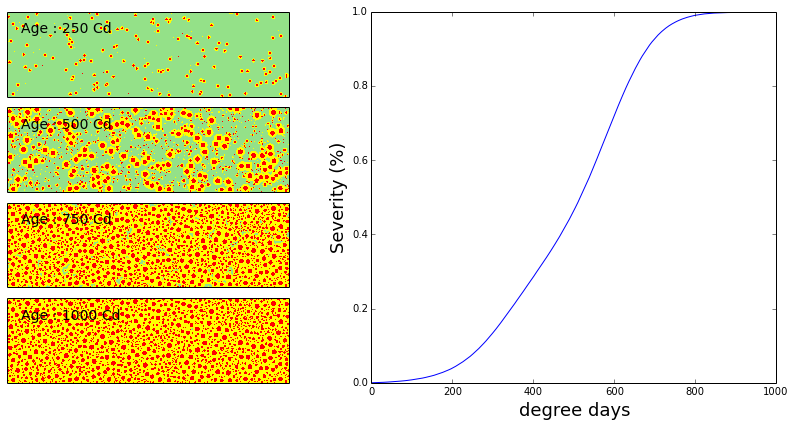

In [14]:
lesions = []
RustLesion.lid = 0
leaf[:,:]=0
competition_model = biological_competition
leaf = init_lesion(leaf, LesionModel = RustLesion, competition_model = competition_model, n = 150)
nb_steps = 1000
sev_rust = []
rcParams['figure.figsize']=(12,6)
gs = gridspec.GridSpec(4, 2)
ax_dict = {250:plt.subplot(gs[0, 0]), 500:plt.subplot(gs[1, 0]), 750:plt.subplot(gs[2, 0]), 1000:plt.subplot(gs[3, 0])}
for i in range(nb_steps):
    for lesion in lesions:
        lesion.growth(dt=1.)
    if i%20==0:
        leaf = disperse_lesion(leaf, lesions, LesionModel=RustLesion, competition_model = competition_model)
    leaf = competition_model(leaf,lesions)
    sev_rust.append(1 - float(sum(leaf==0))/size(leaf))
    if i+1 in ax_dict:
        a = i+1
        plot_leaf(leaf, lesions, ax = ax_dict[a])
        ax_dict[a].annotate('Age : %d Cd' %a, xy=(0.05, 0.75), xycoords='axes fraction', fontsize=14)
        
ax = plt.subplot(gs[:, 1])
ax.plot(sev_rust)
ax.set_ylabel('Severity (%)', fontsize = 18)
ax.set_xlabel('degree days', fontsize = 18)
ax.set_ylim([0,1])
plt.tight_layout()
rcParams['figure.figsize']=(8,8)

## Test the competition inter-species

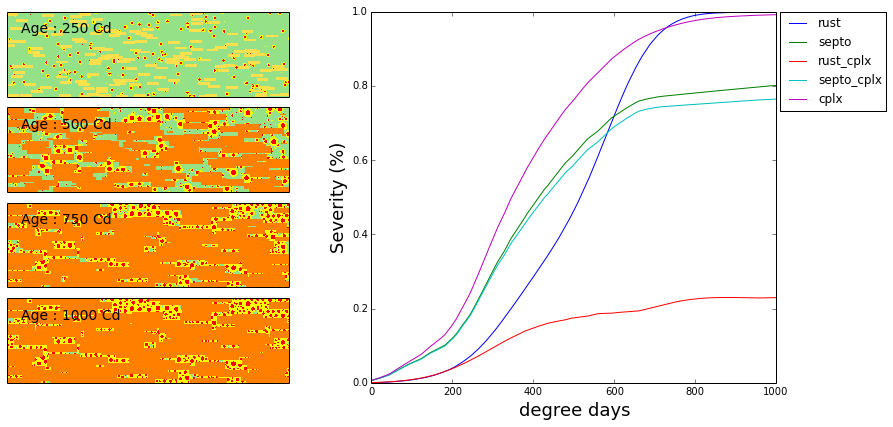

In [15]:
rcParams['figure.figsize']=(12,6)
lesions = []
SeptoLesion.lid = 0
RustLesion.lid = 0
leaf[:,:]=0
competition_model = biological_competition

leaf = init_lesion(leaf, LesionModel = SeptoLesion, competition_model = competition_model, n = 150)
leaf = init_lesion(leaf, LesionModel = RustLesion, competition_model = competition_model, n = 150)

nb_steps = 1000
sev_rust_cplx = []
sev_septo_cplx = []
sev_cplx = []
gs = gridspec.GridSpec(4, 2)
ax_dict = {250:plt.subplot(gs[0, 0]), 500:plt.subplot(gs[1, 0]), 750:plt.subplot(gs[2, 0]), 1000:plt.subplot(gs[3, 0])}
ddays = np.arange(nb_steps)
for i in ddays:
    for lesion in lesions:
        lesion.growth(dt=1.)
    if i%100==0:
        leaf = disperse_lesion(leaf, lesions, LesionModel=SeptoLesion, competition_model = competition_model)
    if i%20==0:
        leaf = disperse_lesion(leaf, lesions, LesionModel=RustLesion, competition_model = competition_model)
    leaf = competition_model(leaf, lesions)
    lesions = [l for l in lesions if l.is_active]
    sev_rust_cplx.append(float(sum(leaf<0))/size(leaf))
    sev_septo_cplx.append(float(sum(leaf>0))/size(leaf))
    sev_cplx.append(1 - float(sum(leaf==0))/size(leaf))
    if i+1 in ax_dict:
        a = i+1
        plot_leaf(leaf, lesions, ax = ax_dict[a])
        ax_dict[a].annotate('Age : %d Cd' %a, xy=(0.05, 0.75), xycoords='axes fraction', fontsize=14)
        
ax = plt.subplot(gs[:, 1])
ax.plot(sev_rust)
plot_smooth(ddays, sev_septo, ax=ax)
plot_smooth(ddays, sev_rust_cplx, ax=ax)
plot_smooth(ddays, sev_septo_cplx, ax=ax)
plot_smooth(ddays, sev_cplx, ax=ax)
ax.set_ylabel('Severity (%)', fontsize = 18)
ax.set_xlabel('degree days', fontsize = 18)
ax.set_ylim([0,1])
ax.set_xlim([0, 1000])
ax.legend(['rust', 'septo', 'rust_cplx', 'septo_cplx', 'cplx'], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
rcParams['figure.figsize']=(8,8)

In [16]:
def simu_compet(n_lesions = 150, d0_rust = None, d0_septo = None, nb_steps = 1500):
    leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
    SeptoLesion.lid = 0
    RustLesion.lid = 0
    if d0_rust == 0:
        leaf = init_lesion(leaf, LesionModel = RustLesion, n=n_lesions)
    if d0_septo == 0:
        leaf = init_lesion(leaf, LesionModel = SeptoLesion, n=n_lesions)
    sev_septo = []
    sev_rust = []
    sev_cplx = []
    ddays = np.arange(nb_steps)
    for i in ddays:
        for lesion in lesions:
            lesion.growth(dt=1.)
        if i==d0_rust:
            leaf = init_lesion(leaf, LesionModel = RustLesion, competition_model = biological_competition, n = 150)
        if i==d0_septo:
            leaf = init_lesion(leaf, LesionModel = SeptoLesion, competition_model = biological_competition, n = 150)    
        if i%100==0:
            leaf = disperse_lesion(leaf, lesions, LesionModel=SeptoLesion)
        if i%20==0:
            leaf = disperse_lesion(leaf, lesions, LesionModel=RustLesion)
        leaf = biological_competition(leaf, lesions)
        sev_septo.append(float(sum(leaf>0))/size(leaf))
        sev_rust.append(float(sum(leaf<0))/size(leaf))
        sev_cplx.append(1 - float(sum(leaf==0))/size(leaf))
    return sev_rust, sev_septo, sev_cplx

In [17]:
lesions = []
leaf[:,:]=0
_, sev_septo_0, _  = simu_compet(d0_rust = None, d0_septo = 0, nb_steps = 1500)

In [18]:
lesions = []
leaf[:,:]=0
_, sev_septo_400, _ = simu_compet(d0_rust = None, d0_septo = 400, nb_steps = 1500)

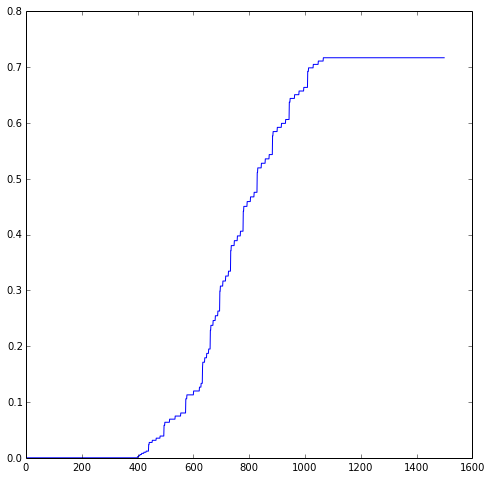

In [19]:
plot(sev_septo_400)

In [20]:
lesions = []
leaf[:,:]=0
sev_rust_0, _, _ = simu_compet(d0_rust = 0, d0_septo = None, nb_steps = 1500)

In [21]:
lesions = []
leaf[:,:]=0
sev_rust_400, _, _ = simu_compet(d0_rust = 400, d0_septo = None, nb_steps = 1500)

In [22]:
lesions = []
leaf[:,:]=0
sev_rust_cplx_400, sev_septo_cplx_0, sev_septo_cplx_prev = simu_compet(d0_rust = 400, d0_septo = 0., nb_steps = 1500)

In [23]:
lesions = []
leaf[:,:]=0
sev_rust_cplx_0, sev_septo_cplx_400, sev_septo_cplx_after = simu_compet(d0_rust = 0, d0_septo = 400., nb_steps = 1500)

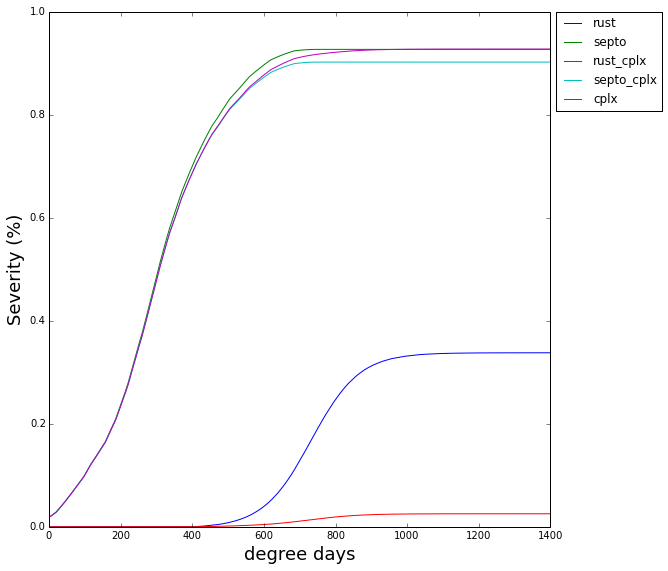

In [24]:
# Septoria before:
ddays = np.arange(len(sev_septo_cplx_prev))
fig, ax = plt.subplots()
ax.plot(sev_rust_400)
plot_smooth(ddays, sev_septo_0, ax=ax)
plot_smooth(ddays, sev_rust_cplx_400, ax=ax)
plot_smooth(ddays, sev_septo_cplx_0, ax=ax)
plot_smooth(ddays, sev_septo_cplx_prev, ax=ax)
ax.set_ylabel('Severity (%)', fontsize = 18)
ax.set_xlabel('degree days', fontsize = 18)
ax.set_ylim([0,1])
ax.set_xlim([0, 1400])
ax.legend(['rust', 'septo', 'rust_cplx', 'septo_cplx', 'cplx'], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
rcParams['figure.figsize']=(8,8)

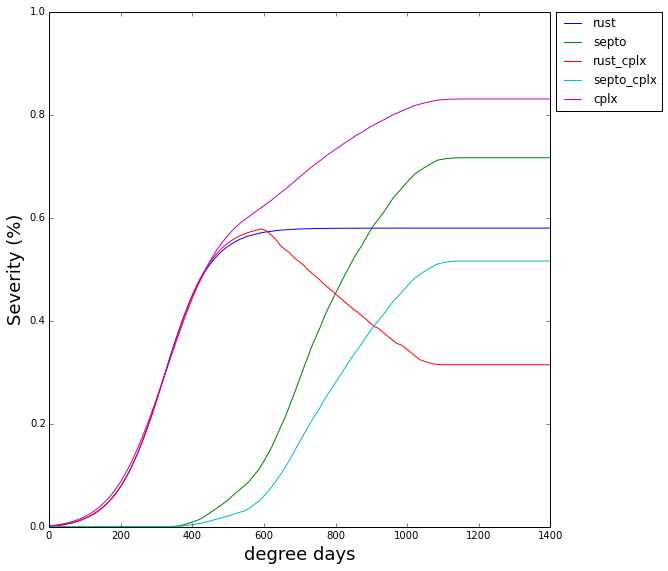

In [25]:
# Septoria after:
ddays = np.arange(len(sev_septo_cplx_after))
fig, ax = plt.subplots()
ax.plot(sev_rust_0)
plot_smooth(ddays, sev_septo_400, ax=ax)
plot_smooth(ddays, sev_rust_cplx_0, box_pts=50, ax=ax)
plot_smooth(ddays, sev_septo_cplx_400, ax=ax)
plot_smooth(ddays, sev_septo_cplx_after, ax=ax)
ax.set_ylabel('Severity (%)', fontsize = 18)
ax.set_xlabel('degree days', fontsize = 18)
ax.set_ylim([0,1])
ax.set_xlim([0, 1400])
ax.legend(['rust', 'septo', 'rust_cplx', 'septo_cplx', 'cplx'], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
rcParams['figure.figsize']=(8,8)

Plot the leaf during the loop
------------------------------


In [ ]:
import matplotlib.animation as animation
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim, videofile=None):
    if not hasattr(anim, '_encoded_video'):
        if videofile:
            anim.save(videofile, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(videofile, "rb").read()
        else:
            with NamedTemporaryFile(suffix='.mp4') as f:
                anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
                video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

#from IPython.display import HTML

def display_animation(anim, videofile=None):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim, videofile))

In [ ]:
fig = plt.figure()

lesions = []
SeptoLesion.lid = 0
RustLesion.lid = 0
leaf[:,:]=0
competition_model = biological_competition

im = imshow(plot_leaf(leaf, return_leaf = True), interpolation = 'nearest')

i = 1
nb_steps = 3000

leaf = init_lesion(leaf, LesionModel = SeptoLesion, competition_model = competition_model, n = 5)
leaf = init_lesion(leaf, LesionModel = RustLesion, competition_model = competition_model, n = 5)

def growth(*args):
    global i, leaf, lesions
    for lesion in lesions:
        lesion.growth(dt=1.)
    if i%200==0:
        leaf = disperse_lesion(leaf, lesions, LesionModel=SeptoLesion, competition_model = competition_model)
    if i%20==0:
        leaf = disperse_lesion(leaf, lesions, LesionModel=RustLesion, competition_model = competition_model)
    leaf = competition_model(leaf, lesions)
    lesions = [l for l in lesions if l.is_active]
    i+=1
    if (i-1)%100==0:
        leaf_color = plot_leaf(leaf, return_leaf = True)
        im.set_data(leaf_color)
    
anim = animation.FuncAnimation(fig, growth, frames=nb_steps, blit=True)
display_animation(anim, "lesions.mp4")

Test the model on a small leaf with two lesions
-----------------------------------------------
The lesion on the left is considered older and will have priority.

In [54]:
L, W = 2, 0.5
dL, dW = 0.01, 0.01
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
X, Y = leaf.shape

def two_lesions(x1, y1, x2, y2, nb_steps=1000):
    leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
    SeptoLesion.lid = 0
    lesions = []
    lesions.append(SeptoLesion(x1,y1))
    px1, py1 = int(x1*X), int(y1*Y)
    if leaf[px1,py1]==0:
        lesions.append(SeptoLesion(x2,y2))
        
    for i in range(nb_steps):
        for lesion in lesions:
            lesion.growth(dt=1.)
        leaf = biological_competition(leaf,lesions)
    return leaf

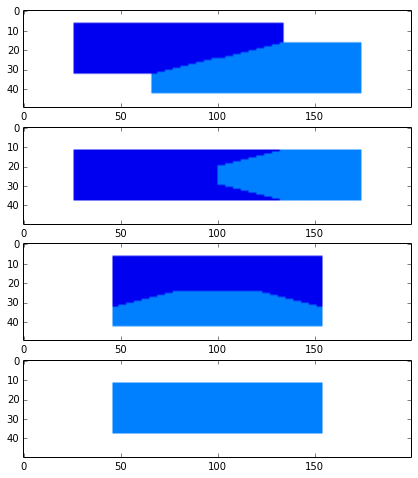

In [55]:
fig = plt.figure()
cmap, bounds, norm = cmap_competition()
im1 = fig.add_subplot(4,1,1)
leaf1 = two_lesions(x1=0.4, y1=0.4, x2=0.6, y2=0.6, nb_steps=1000)
im2 = fig.add_subplot(4,1,2)
leaf2 = two_lesions(x1=0.4, y1=0.5, x2=0.6, y2=0.5, nb_steps=1000)
im3 = fig.add_subplot(4,1,3)
leaf3 = two_lesions(x1=0.5, y1=0.4, x2=0.5, y2=0.6, nb_steps=1000)
im4 = fig.add_subplot(4,1,4)
leaf4 = two_lesions(x1=0.5, y1=0.5, x2=0.5, y2=0.5, nb_steps=1000)
im1.imshow(leaf1.T, cmap=cmap)
im2.imshow(leaf2.T, cmap=cmap)
im3.imshow(leaf3.T, cmap=cmap)
im4.imshow(leaf4.T, cmap=cmap)

In [38]:
L, W = 2, 0.5
dL, dW = 0.01, 0.01
ind_leaf = np.arange(L/dL * W/dW).reshape(L/dL, W/dW)
X, Y = leaf.shape
def two_lesions_circle(x1, y1, x2, y2, nb_steps=1000):
    leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
    RustLesion.lid = 0
    lesions = []
    lesions.append(RustLesion(x1,y1))
    px1, py1 = int(x1*X), int(y1*Y)
    if leaf[px1,py1]==0:
        lesions.append(RustLesion(x2,y2))
        
    for i in range(nb_steps):
        for lesion in lesions:
            lesion.growth(dt=1.)
        leaf = biological_competition(leaf,lesions)
    return leaf

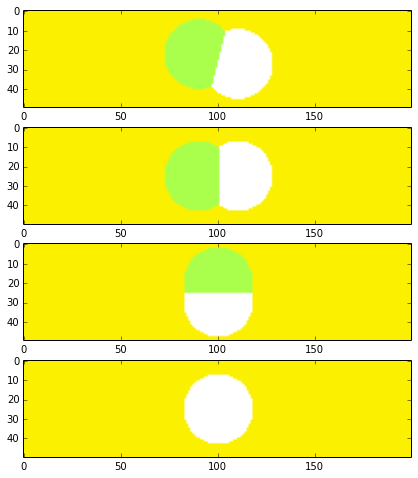

In [44]:
fig = plt.figure()
cmap, bounds, norm = cmap_competition()
im1 = fig.add_subplot(4,1,1)
leaf1 = two_lesions_circle(x1=0.45, y1=0.45, x2=0.55, y2=0.55, nb_steps=1000)
im2 = fig.add_subplot(4,1,2)
leaf2 = two_lesions_circle(x1=0.45, y1=0.5, x2=0.55, y2=0.5, nb_steps=1000)
im3 = fig.add_subplot(4,1,3)
leaf3 = two_lesions_circle(x1=0.5, y1=0.4, x2=0.5, y2=0.6, nb_steps=1000)
im4 = fig.add_subplot(4,1,4)
leaf4 = two_lesions_circle(x1=0.5, y1=0.5, x2=0.5, y2=0.5, nb_steps=1000)
im1.imshow(leaf1.T, cmap=cmap)
im2.imshow(leaf2.T, cmap=cmap)
im3.imshow(leaf3.T, cmap=cmap)
im4.imshow(leaf4.T, cmap=cmap)

In [77]:
L, W = 2, 0.5
dL, dW = 0.01, 0.01
ind_leaf = np.arange(L/dL * W/dW).reshape(L/dL, W/dW)
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
X, Y = leaf.shape

def competition_2_lesions(les_models = [RustLesion, SeptoLesion], positions = [(0.45, 0.45), (0.55, 0.55)], nb_steps = 1000):
    leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
    les_models[0].lid = 0
    les_models[1].lid = 0
    lesions = []
    x1,y1 = positions[0]
    lesions.append(les_models[0](x1,y1))
    px1, py1 = int(x1*X), int(y1*Y)
    if leaf[px1,py1]==0:
        x2,y2 = positions[1]
        lesions.append(les_models[1](x2,y2))
    for i in range(nb_steps):
        for lesion in lesions:
            lesion.growth(dt=1.)
        leaf = biological_competition(leaf,lesions)
    return leaf

from math import floor
def plot2lesions(les_models = [[SeptoLesion, SeptoLesion], [RustLesion, RustLesion], [RustLesion, SeptoLesion]],
                 positions = [[(0.45, 0.45), (0.55, 0.55)], [(0.45, 0.5), (0.55, 0.5)],
                              [(0.5, 0.4), (0.5, 0.6)], [(0.5, 0.5), (0.5, 0.5)]],
                 nb_steps = 1000):
    fig, axs = plt.subplots(len(positions), len(les_models))
    for i, ax in enumerate(axs.flat):
        models = les_models[i%len(les_models)]
        pos = positions[int(floor(i/len(les_models)))]
        lf = competition_2_lesions(les_models=models, positions=pos, nb_steps=nb_steps)
        lf_color = np.array([[np.array([1., 1., 1.]) for i in range(len(line))] for line in lf])

        lf_color[np.where(lf==1)] = np.array([1., 0., 0.])
        lf_color[np.where(lf==2)] = np.array([0., 0., 1.])
        lf_color[np.where(lf==-1)] = np.array([0., 0., 1.])
        lf_color[np.where(lf==-2)] = np.array([1., 0., 0.])
        
        ax.imshow(lf_color.transpose((1,0,2)), cmap=cmap)
        #ax.imshow(lf.T, cmap=cmap)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.tight_layout()

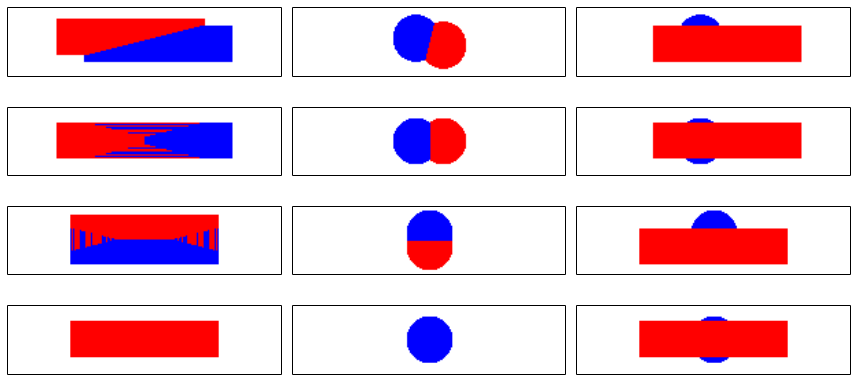

In [78]:
rcParams['figure.figsize']=(12,6)
plot2lesions()

## Comparison with average approach

In [26]:
class AvgSeptoLesion(object):
    lid = 0.
    ratio = 4.
    dS = 0.0006
    dS0 = 0.03/220.
    dE = 1.7
    age_chlo = 220.
    age_spo = 330.
    # Temp G. Garin 27/01/2016 : Test no growth during incubation
    #age_grow = 200.
    #dS0 = 0.03/20.
    def __init__(self, x, y, lid = None):
        self.age = 0
        self.Smax = 0.3
        SeptoLesion.lid += 1
        self.lid = SeptoLesion.lid
        self.is_active = True
        self.growth_is_active = True
        self.surface = 0.
        self.pot_surface = 0.
        
    def reset(self):
        SeptoLesion.lid=0

    def growth(self, dt):
        if self.growth_is_active and self.age<self.age_chlo:
            self.growth_demand = self.dS0 * dt
            # Temp G. Garin 27/01/2016 : Test no growth during incubation
            #if self.age >= self.age_grow:
            #    self.growth_demand = self.dS0 * dt
            #else:
            #    self.growth_demand = 0.
        elif self.growth_is_active and self.age >= self.age_chlo:
            self.growth_demand = self.dS * dt
        else:
            self.growth_demand = 0.
        self.age += dt
        self.pot_surface += self.growth_demand
        if not self.growth_is_active and self.surface == 0.:
            self.is_active = False
            
    def control_growth(self, growth_offer = 0.):
        self.surface = min(self.Smax, self.surface + growth_offer)
        self.Smax -= (self.growth_demand - growth_offer)
        if round(self.surface, 10) == round(self.Smax,10):
            self.growth_is_active = False
    
    def emission(self):
        if self.age >= self.age_spo: 
            return self.surface * self.dE
        else:
            return 0.
    
    def disable(self):
        self.is_active = False
    
    @property
    def is_incubating(self):
        return True if self.age < self.age_chlo else False
    
    @property
    def is_chlorotic(self):
        return True if self.age >= self.age_chlo and self.age < self.age_spo else False
    
    @property
    def is_sporulating(self):
        return True if self.age >= self.age_spo else False

In [32]:
class AvgRustLesion(object):
    lid = 0.
    k = 0.015
    x0 = 350.
    dE = 1.7
    age_spo = 180
    age_end_spo = 800
    ratio_spo = 0.3
    def __init__(self, x, y):
        self.age = 0
        self.x = x
        self.y = y
        self.r = 0.
        self.Smax = 0.09
        RustLesion.lid -= 1
        self.lid = RustLesion.lid
        self.is_active = True
        self.growth_is_active = True
        self.surface = 0.
        self.pot_surface = 0.
        
    def reset(self):
        RustLesion.lid=0
    
    def logistic(self, x):
        return self.Smax/(1.+np.exp(-self.k*(x-self.x0)))

    def growth(self, dt):
        if self.growth_is_active:
            self.growth_demand = self.logistic(self.age+dt) - self.logistic(self.age)
        else:
            self.growth_demand = 0.
        self.age += dt
        self.pot_surface += self.growth_demand
        if round(self.surface,6)==self.Smax and self.age >= self.age_end_spo:
            self.disable()
        if not self.growth_is_active and self.surface == 0.:
            self.is_active = False
    
    def control_growth(self, growth_offer = 0.):
        self.surface = min(self.Smax, self.surface + growth_offer)      
        #self.Smax -= (self.growth_demand - growth_offer)
        if round(self.surface, 10) == round(self.Smax,10):
            self.growth_is_active = False
    
    def emission(self):
        if self.age >= self.age_spo and self.age < self.age_end_spo: 
            return self.surface * self.dE
        else:
            return 0.
        
    def disable(self):
        self.is_active = False

In [33]:
def true_area_impacted(nb_lesions, leaf_area, mean_lesion_size):
    if leaf_area>0.:
        return leaf_area*(1-np.exp(-nb_lesions*mean_lesion_size/leaf_area))
    else:
        return 0.

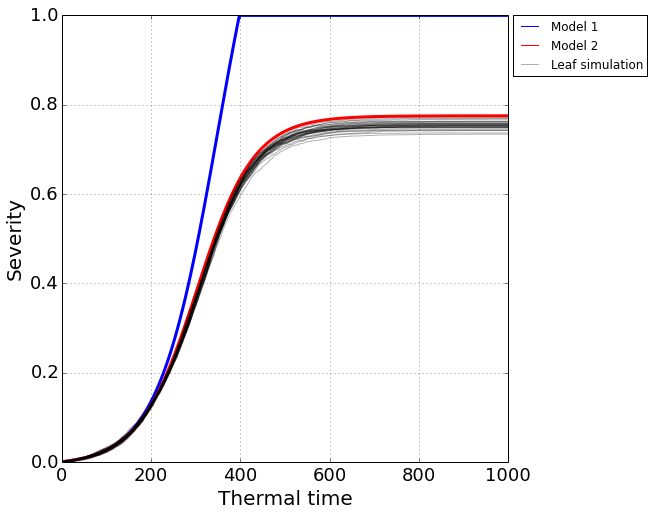

In [34]:
L, W = 10, 3
dL, dW = 0.1, 0.1
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
X, Y = leaf.shape
nb_lesions = 500

# Average approach
s_leaf = L * W
nb_steps = 1000
lesions = [AvgRustLesion(0.5, 0.5) for i in range(nb_lesions)]
sev_avg = []
for i in range(nb_steps):
    s_rust = 0.
    for l in lesions:
        s_rust += l.surface
        l.growth(dt = 1.)
    demand = sum(l.growth_demand for l in lesions)
    offer = min(demand, s_leaf - s_rust)
    for l in lesions:
        offer_lesion = offer * l.growth_demand / demand if demand > 0. else 0.
        l.control_growth(offer_lesion)
    sev_avg.append(float(s_rust) / s_leaf)
    
# Poisson approach
lesions = [AvgRustLesion(0.5, 0.5) for i in range(nb_lesions)]
sev_poi = []
s_rust_no_limit = 0.
for i in range(nb_steps):
    s_rust = 0.
    for l in lesions:
        s_rust += l.surface
        l.growth(dt = 1.)
        
    total_demand = sum(l.growth_demand for l in lesions)    
    s_rust_no_limit += total_demand
    true_area = true_area_impacted(nb_lesions, s_leaf, s_rust_no_limit/nb_lesions)
    offer = true_area - s_rust        
    for l in lesions:
        offer_lesion = l.growth_demand * offer/total_demand if total_demand>0. else 0.
        l.control_growth(offer_lesion)
    sev_poi.append(float(s_rust) / s_leaf)
    
# Geom approach
tries = {k:[] for k in range(30)}
for k in tries.iterkeys():
    lesions = []
    RustLesion.lid = 0
    leaf[:,:]=0
    competition_model = biological_competition
    leaf = init_lesion(leaf, LesionModel = RustLesion, competition_model = competition_model, n = nb_lesions)
    for i in range(nb_steps):
        for lesion in lesions:
            lesion.growth(dt=1.)
        leaf = competition_model(leaf,lesions)
        tries[k].append(1 - float(sum(leaf==0))/size(leaf))
    
fig, ax = plt.subplots()
ax.plot(range(nb_steps), sev_avg, linewidth=3)
ax.plot(range(nb_steps), sev_poi, 'r', linewidth=3)
for sev_geom in tries.itervalues():
    ax.plot(range(nb_steps), sev_geom, 'k', alpha = 0.3)
ax.set_ylim([0, 1])
ax.set_xlabel('Thermal time', fontsize = 20)
ax.set_ylabel('Severity', fontsize = 20)
ax.grid(alpha=0.8)
proxys = [plt.Line2D((0,1),(0,0), color='b'),
         plt.Line2D((0,1),(0,0), color='r'),
         plt.Line2D((0,1),(0,0), color='k', alpha=0.3)]
labels = ['Model 1', 'Model 2', 'Leaf simulation']
ax.legend(proxys, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax.tick_params(axis='both', labelsize=18)

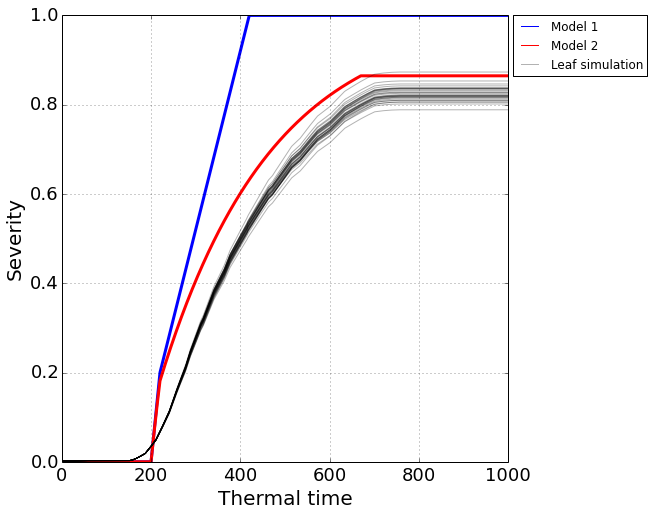

In [35]:
L, W = 10, 3
dL, dW = 0.01, 0.01
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
X, Y = leaf.shape
nb_lesions = 200

# Average approach
s_leaf = L * W
nb_steps = 1000
lesions = [AvgSeptoLesion(0.5, 0.5) for i in range(nb_lesions)]
sev_avg = []
for i in range(nb_steps):
    s_septo = 0.
    for l in lesions:
        s_septo += l.surface
        l.growth(dt = 1.)
    demand = sum(l.growth_demand for l in lesions)
    offer = min(demand, s_leaf - s_septo)
    for l in lesions:
        offer_lesion = offer * l.growth_demand / demand if demand > 0. else 0.
        l.control_growth(offer_lesion)
    sev_avg.append(float(s_septo) / s_leaf)
    
# Poisson approach
lesions = [AvgSeptoLesion(0.5, 0.5) for i in range(nb_lesions)]
sev_poi = []
s_septo_no_limit = 0.
for i in range(nb_steps):
    s_septo = 0.
    for l in lesions:
        s_septo += l.surface
        l.growth(dt = 1.)
        
    total_demand = sum(l.growth_demand for l in lesions)    
    s_septo_no_limit += total_demand
    true_area = true_area_impacted(nb_lesions, s_leaf, s_septo_no_limit/nb_lesions)
    offer = true_area - s_septo        
    for l in lesions:
        offer_lesion = l.growth_demand * offer/total_demand if total_demand>0. else 0.
        l.control_growth(offer_lesion)
    sev_poi.append(float(s_septo) / s_leaf)
    
# Geom approach
tries = {k:[] for k in range(30)}
for k in tries.iterkeys():
    lesions = []
    SeptoLesion.lid = 0
    leaf[:,:]=0
    competition_model = biological_competition
    leaf = init_lesion(leaf, LesionModel = SeptoLesion, competition_model = competition_model, n = nb_lesions)
    for i in range(nb_steps):
        for lesion in lesions:
            lesion.growth(dt=1.)
        leaf = competition_model(leaf,lesions)
        tries[k].append(1 - float(sum(leaf==0))/size(leaf))
    
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(range(nb_steps), sev_avg, linewidth=3)
ax.plot(range(nb_steps), sev_poi, 'r', linewidth=3)
for sev_geom in tries.itervalues():
    plot_smooth(range(nb_steps), sev_geom, ax=ax, color='k', alpha = 0.3)
ax.set_ylim([0, 1])
ax.set_xlim([0, 1000])
ax.set_xlabel('Thermal time', fontsize = 20)
ax.set_ylabel('Severity', fontsize = 20)
ax.grid(alpha=0.8)
proxys = [plt.Line2D((0,1),(0,0), color='b'),
         plt.Line2D((0,1),(0,0), color='r'),
         plt.Line2D((0,1),(0,0), color='k', alpha=0.3)]
labels = ['Model 1', 'Model 2', 'Leaf simulation']
ax.legend(proxys, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax.tick_params(axis='both', labelsize=18)

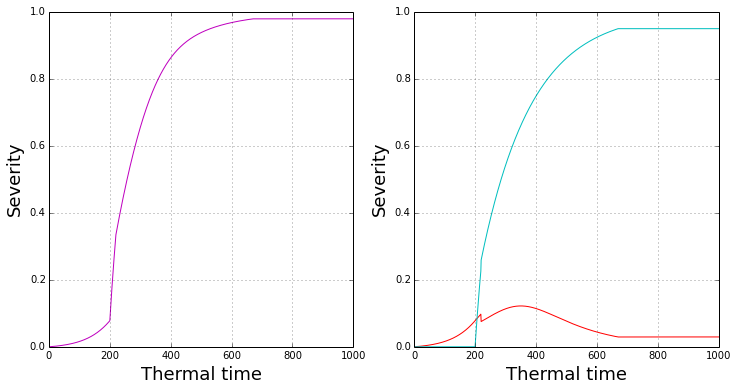

In [36]:
L, W = 10, 1.
dL, dW = 0.1, 0.1
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
X, Y = leaf.shape
nb_lesions = 100
s_leaf = L * W
nb_steps = 1200

# Poisson approach
lesions = [AvgRustLesion(0.5, 0.5) for i in range(nb_lesions)]
lesions += [AvgSeptoLesion(0.5, 0.5) for i in range(nb_lesions)]
sev_poi_cplx = []
sev_poi_rust = []
sev_poi_septo = []
sev_prio = []
sev_non_prio = []
for i in range(nb_steps):
    s_rust = sum([l.surface for l in lesions if isinstance(l, AvgRustLesion)])
    s_septo = sum([l.surface for l in lesions if isinstance(l, AvgSeptoLesion)])
    s_prio = 0.
    s_non_prio = 0.
    s_pot_prio = 0.
    s_pot_non_prio = 0.
    demand_prio = 0.
    demand_non_prio = 0.
    true_area_prio = 0.
    prio_les = []
    non_prio_les = []
    for l in lesions:    
        l.growth(dt = 1.)
        if isinstance(l, AvgSeptoLesion) and (l.is_chlorotic or l.is_sporulating):
            s_prio += l.surface
            s_pot_prio += l.pot_surface
            prio_les.append(l)
            demand_prio += l.growth_demand
        else:
            s_non_prio += l.surface
            s_pot_non_prio += l.pot_surface
            non_prio_les.append(l)
            demand_non_prio += l.growth_demand
    
    if len(prio_les)>0:
        true_area_prio = true_area_impacted(len(prio_les), s_leaf, s_pot_prio/len(prio_les))  
        offer_prio = true_area_prio - s_prio
        for l in prio_les:
            offer_lesion = l.growth_demand * offer_prio/demand_prio if demand_prio>0. else 0.
            l.control_growth(offer_lesion)
    else:
        offer_prio = 0.

    if len(non_prio_les)>0:
        nb_les = len(non_prio_les) + len(prio_les)
        s_pot = s_pot_non_prio + s_pot_prio
        true_area_non_prio = true_area_impacted(nb_les, s_leaf, s_pot/nb_les)
        offer_non_prio = true_area_non_prio - s_non_prio - true_area_prio
        #if i >= 219:
          #  import pdb
           # pdb.set_trace()
        for l in non_prio_les:
            if offer_non_prio >= 0:
                offer_lesion = l.growth_demand * offer_non_prio/demand_non_prio if demand_non_prio>0. else 0.
            else:
                offer_lesion = offer_non_prio * l.surface/s_non_prio if s_non_prio>0. else 0.
            l.control_growth(offer_lesion)

    sev_poi_cplx.append(float(s_rust + s_septo) / s_leaf)
    sev_poi_rust.append(float(s_rust) / s_leaf)
    sev_poi_septo.append(float(s_septo) / s_leaf)
    
rcParams['figure.figsize']=(12,6)
fig, axs = plt.subplots(1,2)
axs[0].plot(range(nb_steps), sev_poi_cplx, 'm')
axs[1].plot(range(nb_steps), sev_poi_rust, 'r')
axs[1].plot(range(nb_steps), sev_poi_septo, 'c')
for ax in axs:
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1000])
    ax.set_xlabel('Thermal time', fontsize = 18)
    ax.set_ylabel('Severity', fontsize = 18)
    ax.grid(alpha=0.8)

In [37]:
L, W = 10, 3
dL, dW = 0.01, 0.01
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
X, Y = leaf.shape
nb_lesions = 200
s_leaf = L * W
nb_steps = 1200

# Poisson approach
lesions = [AvgRustLesion(0.5, 0.5) for i in range(nb_lesions)]
lesions += [AvgSeptoLesion(0.5, 0.5) for i in range(nb_lesions)]
sev_poi_cplx = []
sev_poi_rust = []
sev_poi_septo = []
sev_prio = []
sev_non_prio = []

for i in range(nb_steps):
    s_rust = sum([l.surface for l in lesions if isinstance(l, AvgRustLesion)])
    s_septo = sum([l.surface for l in lesions if isinstance(l, AvgSeptoLesion)])
    s_prio = 0.
    s_non_prio = 0.
    s_pot_prio = 0.
    s_pot_non_prio = 0.
    demand_prio = 0.
    demand_non_prio = 0.
    true_area_prio = 0.
    prio_les = []
    non_prio_les = []
    for l in lesions:
        l.growth(dt = 1.)
        if isinstance(l, AvgSeptoLesion) and (l.is_chlorotic or l.is_sporulating):
            s_prio += l.surface
            s_pot_prio += l.pot_surface
            prio_les.append(l)
            demand_prio += l.growth_demand
        else:
            s_non_prio += l.surface
            s_pot_non_prio += l.pot_surface
            non_prio_les.append(l)
            demand_non_prio += l.growth_demand
    
    if len(prio_les)>0:
        true_area_prio = true_area_impacted(len(prio_les), s_leaf, s_pot_prio/len(prio_les))  
        offer_prio = true_area_prio - s_prio
        for l in prio_les:
            offer_lesion = l.growth_demand * offer_prio/demand_prio if demand_prio>0. else 0.
            l.control_growth(offer_lesion)
    else:
        offer_prio = 0.

    if len(non_prio_les)>0:
        nb_les = len(non_prio_les) + len(prio_les)
        s_pot = s_pot_non_prio + s_pot_prio
        true_area_non_prio = true_area_impacted(nb_les, s_leaf, s_pot/nb_les)
        offer_non_prio = true_area_non_prio - s_non_prio - true_area_prio
        for l in non_prio_les:
            offer_lesion = l.growth_demand * offer_non_prio/demand_non_prio if demand_non_prio>0. else 0.
            l.control_growth(offer_lesion)
        
    sev_poi_cplx.append(float(s_prio + s_non_prio) / s_leaf)
    sev_poi_rust.append(float(s_rust) / s_leaf)
    sev_poi_septo.append(float(s_septo) / s_leaf)
    sev_prio.append(float(s_prio) / s_leaf)
    sev_non_prio.append(float(s_non_prio) / s_leaf)
    
# Geom approach
tries = {k:{'septo':[], 'rust':[], 'cplx':[]} for k in range(30)}
for k in tries.iterkeys():
    print k
    lesions = []
    SeptoLesion.lid = 0
    RustLesion.lid = 0
    leaf[:,:]=0
    competition_model = biological_competition
    leaf = init_lesion(leaf, LesionModel = SeptoLesion, competition_model = competition_model, n = nb_lesions)
    leaf = init_lesion(leaf, LesionModel = RustLesion, competition_model = competition_model, n = nb_lesions)
    for i in range(nb_steps):
        for lesion in lesions:
            lesion.growth(dt=1.)
        leaf = competition_model(leaf,lesions)
        tries[k]['septo'].append(float(sum(leaf>0))/size(leaf))
        tries[k]['rust'].append(float(sum(leaf<0))/size(leaf))
        tries[k]['cplx'].append(1 - float(sum(leaf==0))/size(leaf))

0


KeyboardInterrupt: 

In [ ]:
rcParams['figure.figsize']=(12,6)
fig, axs = plt.subplots(1,2)
axs[0].plot(range(nb_steps), sev_poi_cplx, 'm', linewidth=3)
axs[1].plot(range(nb_steps), sev_poi_rust, 'r', linewidth=3)
axs[1].plot(range(nb_steps), sev_poi_septo, 'c', linewidth=3)
for sev_geom in tries.itervalues():
    plot_smooth(range(nb_steps), sev_geom['cplx'], ax=axs[0], color='k', alpha = 0.3)
    plot_smooth(range(nb_steps), sev_geom['rust'], ax=axs[1], color='k', alpha = 0.3)
    plot_smooth(range(nb_steps), sev_geom['septo'], ax=axs[1], color='k', alpha = 0.3)
for ax in axs:
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1000])
    ax.set_xlabel('Thermal time', fontsize = 20)
    ax.set_ylabel('Severity', fontsize = 20)
    ax.grid(alpha=0.8)
proxys = [plt.Line2D((0,1),(0,0), color='m'),
          plt.Line2D((0,1),(0,0), color='r'),
          plt.Line2D((0,1),(0,0), color='c'),
          plt.Line2D((0,1),(0,0), color='k', alpha=0.3)]
labels = ['Model 2 - complex', 'Model 2 - rust', 'Model 2 - septoria', 'Leaf simulation']
axs[1].legend(proxys, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axs[0].tick_params(axis='both', labelsize=18)
axs[1].tick_params(axis='both', labelsize=18)

In [ ]:
def generate_sequence(seq_length=1000, proba=0.2, n_max=10):
    x = np.zeros(seq_length)
    for i,_ in enumerate(x):
        if np.random.random()<proba:
            x[i] = np.random.randint(n_max)
    return x
        
seq_rust = generate_sequence(seq_length=1000, proba=0.2, n_max=10)
seq_septo = generate_sequence(seq_length=1000, proba=0.2, n_max=10)

L, W = 10, 3.
dL, dW = 0.1, 0.1
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
X, Y = leaf.shape
nb_lesions = 100
s_leaf = L * W
nb_steps = 1000

# Poisson approach
lesions = []
sev_poi_cplx = []
sev_poi_rust = []
sev_poi_septo = []
sev_prio = []
sev_non_prio = []
for i in range(nb_steps):
    new_rust_lesions = int(seq_rust[i])
    if new_rust_lesions>0:
        lesions += [AvgRustLesion(0.5, 0.5) for i in range(new_rust_lesions)]
        
    new_septo_lesions = int(seq_septo[i])
    if new_septo_lesions>0:
        lesions += [AvgSeptoLesion(0.5, 0.5) for i in range(new_septo_lesions)]
        
    s_rust = sum([l.surface for l in lesions if isinstance(l, AvgRustLesion)])
    s_septo = sum([l.surface for l in lesions if isinstance(l, AvgSeptoLesion)])
    s_prio = 0.
    s_non_prio = 0.
    s_pot_prio = 0.
    s_pot_non_prio = 0.
    demand_prio = 0.
    demand_non_prio = 0.
    true_area_prio = 0.
    prio_les = []
    non_prio_les = []
    for l in lesions:    
        l.growth(dt = 1.)
        if isinstance(l, AvgSeptoLesion) and (l.is_chlorotic or l.is_sporulating):
            s_prio += l.surface
            s_pot_prio += l.pot_surface
            prio_les.append(l)
            demand_prio += l.growth_demand
        else:
            s_non_prio += l.surface
            s_pot_non_prio += l.pot_surface
            non_prio_les.append(l)
            demand_non_prio += l.growth_demand
    
    if len(prio_les)>0:
        true_area_prio = true_area_impacted(len(prio_les), s_leaf, s_pot_prio/len(prio_les))  
        offer_prio = true_area_prio - s_prio
        for l in prio_les:
            offer_lesion = l.growth_demand * offer_prio/demand_prio if demand_prio>0. else 0.
            l.control_growth(offer_lesion)
    else:
        offer_prio = 0.

    if len(non_prio_les)>0:
        nb_les = len(non_prio_les) + len(prio_les)
        s_pot = s_pot_non_prio + s_pot_prio
        true_area_non_prio = true_area_impacted(nb_les, s_leaf, s_pot/nb_les)
        offer_non_prio = true_area_non_prio - s_non_prio - true_area_prio
        for l in non_prio_les:
            if offer_non_prio >= 0:
                offer_lesion = l.growth_demand * offer_non_prio/demand_non_prio if demand_non_prio>0. else 0.
            else:
                offer_lesion = offer_non_prio * l.surface/s_non_prio if s_non_prio>0. else 0.
            l.control_growth(offer_lesion)

    sev_poi_cplx.append(float(s_rust + s_septo) / s_leaf)
    sev_poi_rust.append(float(s_rust) / s_leaf)
    sev_poi_septo.append(float(s_septo) / s_leaf)
    
rcParams['figure.figsize']=(12,6)
fig, axs = plt.subplots(1,2)
axs[0].plot(range(nb_steps), sev_poi_cplx, 'm')
axs[1].plot(range(nb_steps), sev_poi_rust, 'r')
axs[1].plot(range(nb_steps), sev_poi_septo, 'c')
for ax in axs:
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1000])
    ax.set_xlabel('Thermal time', fontsize = 18)
    ax.set_ylabel('Severity', fontsize = 18)
    ax.grid(alpha=0.8)

In [ ]:
def generate_sequence(seq_length=1000, proba=0.2, n_max=10):
    x = np.zeros(seq_length)
    for i,_ in enumerate(x):
        if np.random.random()<proba:
            x[i] = np.random.randint(n_max)
    return x

nb_steps = 1200
seq_rust = generate_sequence(seq_length=nb_steps, proba=0.2, n_max=10)
seq_septo = generate_sequence(seq_length=nb_steps, proba=0.2, n_max=10)

L, W = 10, 3.
dL, dW = 0.05, 0.05
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
X, Y = leaf.shape
nb_lesions = 100
s_leaf = L * W

# Poisson approach
np.random.seed(0)
lesions = []
sev_poi_cplx = []
sev_poi_rust = []
sev_poi_septo = []
sev_prio = []
sev_non_prio = []
for i in range(nb_steps):
    new_rust_lesions = int(seq_rust[i])
    if new_rust_lesions>0:
        lesions += [AvgRustLesion(0.5, 0.5) for i in range(new_rust_lesions)]

    new_septo_lesions = int(seq_septo[i])
    if new_septo_lesions>0:
        lesions += [AvgSeptoLesion(0.5, 0.5) for i in range(new_septo_lesions)]
        
    s_rust = sum([l.surface for l in lesions if isinstance(l, AvgRustLesion)])
    s_septo = sum([l.surface for l in lesions if isinstance(l, AvgSeptoLesion)])
    s_prio = 0.
    s_non_prio = 0.
    s_pot_prio = 0.
    s_pot_non_prio = 0.
    demand_prio = 0.
    demand_non_prio = 0.
    true_area_prio = 0.
    prio_les = []
    non_prio_les = []
    for l in lesions:
        l.growth(dt = 1.)
        if isinstance(l, AvgSeptoLesion) and (l.is_chlorotic or l.is_sporulating):
            s_prio += l.surface
            s_pot_prio += l.pot_surface
            prio_les.append(l)
            demand_prio += l.growth_demand
        else:
            s_non_prio += l.surface
            s_pot_non_prio += l.pot_surface
            non_prio_les.append(l)
            demand_non_prio += l.growth_demand
    
    if len(prio_les)>0:
        true_area_prio = true_area_impacted(len(prio_les), s_leaf, s_pot_prio/len(prio_les))  
        offer_prio = true_area_prio - s_prio
        for l in prio_les:
            offer_lesion = l.growth_demand * offer_prio/demand_prio if demand_prio>0. else 0.
            l.control_growth(offer_lesion)
    else:
        offer_prio = 0.

    #ratio_newly_occupied = offer_prio/(s_leaf - s_prio)
    if len(non_prio_les)>0:
        nb_les = len(non_prio_les) + len(prio_les)
        s_pot = s_pot_non_prio + s_pot_prio
        true_area_non_prio = true_area_impacted(nb_les, s_leaf, s_pot/nb_les)
        offer_non_prio = true_area_non_prio - s_non_prio - true_area_prio
        for l in non_prio_les:
            offer_lesion = l.growth_demand * offer_non_prio/demand_non_prio if demand_non_prio>0. else 0.
            l.control_growth(offer_lesion)
        
    sev_poi_cplx.append(float(s_prio + s_non_prio) / s_leaf)
    sev_poi_rust.append(float(s_rust) / s_leaf)
    sev_poi_septo.append(float(s_septo) / s_leaf)
    sev_prio.append(float(s_prio) / s_leaf)
    sev_non_prio.append(float(s_non_prio) / s_leaf)
    
# Geom approach
tries = {k:{'septo':[], 'rust':[], 'cplx':[]} for k in range(1)}
for k in tries.iterkeys():
    print k
    np.random.seed(0)
    lesions = []
    SeptoLesion.lid = 0
    RustLesion.lid = 0
    leaf[:,:]=0
    competition_model = biological_competition
    for i in range(nb_steps):
        new_rust_lesions = int(seq_rust[i])
        if new_rust_lesions>0:
            leaf = init_lesion(leaf, LesionModel = RustLesion, competition_model = competition_model, n = new_rust_lesions)

        new_septo_lesions = int(seq_septo[i])
        if new_septo_lesions>0:
            leaf = init_lesion(leaf, LesionModel = SeptoLesion, competition_model = competition_model, n = new_septo_lesions)
        
        for lesion in lesions:
            lesion.growth(dt=1.)
        leaf = competition_model(leaf,lesions)
        tries[k]['septo'].append(float(sum(leaf>0))/size(leaf))
        tries[k]['rust'].append(float(sum(leaf<0))/size(leaf))
        tries[k]['cplx'].append(1 - float(sum(leaf==0))/size(leaf))
        
rcParams['figure.figsize']=(12,6)
fig, axs = plt.subplots(1,2)
axs[0].plot(range(nb_steps), sev_poi_cplx, 'm')
axs[1].plot(range(nb_steps), sev_poi_rust, 'r')
axs[1].plot(range(nb_steps), sev_poi_septo, 'c')
for sev_geom in tries.itervalues():
    plot_smooth(range(nb_steps), sev_geom['cplx'], ax=axs[0], color='k', alpha = 0.3)
    plot_smooth(range(nb_steps), sev_geom['rust'], ax=axs[1], color='k', alpha = 0.3)
    plot_smooth(range(nb_steps), sev_geom['septo'], ax=axs[1], color='k', alpha = 0.3)
for ax in axs:
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1000])
    ax.set_xlabel('Thermal time', fontsize = 18)
    ax.set_ylabel('Severity', fontsize = 18)
    ax.grid(alpha=0.8)
proxys = [plt.Line2D((0,1),(0,0), color='m'),
          plt.Line2D((0,1),(0,0), color='r'),
          plt.Line2D((0,1),(0,0), color='c'),
          plt.Line2D((0,1),(0,0), color='k', alpha=0.3)]
labels = ['Model 2 - complex', 'Model 2 - rust', 'Model 2 - septoria', 'Leaf simulation']
axs[1].legend(proxys, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [ ]:
plot(seq_rust,'o')
plot(seq_septo, 'ro')